In [1]:
import itertools
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from enum import Enum
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, WordEmbeddingSimilarityIndex
from gensim.models.fasttext import load_facebook_model
from gensim.similarities import Similarity, SoftCosineSimilarity, SparseTermSimilarityMatrix, WmdSimilarity
from gensim.test.utils import get_tmpfile
from keras import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from lightgbm import LGBMClassifier
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, StratifiedShuffleSplit, \
    validation_curve
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import compute_class_weight

Using TensorFlow backend.


In [2]:
DATA_DIR = 'data'

COMPANY_TRAINING_DATA_FILENAME = "company_training_data.csv"
INVESTOR_TRAINING_DATA_FILENAME = "investor_training_data.csv"
LP_TRAINING_DATA_FILENAME = "lp_training_data.csv"
SP_TRAINING_DATA_FILENAME = "sp_training_data.csv"

FASTTEXT_MODEL_NAME = 'cc.en.300.bin'
COUNT_VECTORIZER_MODEL_NAME = 'count_vec.mdl'
MULTI_LR_MODEL_NAME = 'multi_class_lr.mdl'
MULTI_LR_CV_MODEL_NAME = 'multi_class_lr_cv.mdl'

with open(os.path.join(DATA_DIR, 'stop_words.csv'), 'r', encoding='utf-8') as f:
    STOP_WORDS = f.readlines()
STOP_WORDS = frozenset([item[:-1] for item in STOP_WORDS])


class VECTORIZE_METHOD(str, Enum):
    """
    Enumeration for vectorization methods
    """
    FAST_TEXT = "ft"
    DOC_2_VEC = "d2v"
    WORD_2_VEC = "w2v"
    BERT = "bert"


class SIMILARITY_MEASURES(str, Enum):
    """
    Enumeration for vectorization methods
    """
    COSINE = "cosine"
    SOFT_COSINE = "soft_cosine"
    WMD = "wmd"

In [3]:
np.set_printoptions(precision=2)

tokenizer = RegexpTokenizer('\W', gaps=True)
wordnet_lemmatizer = WordNetLemmatizer()
vectors = None
vectorize_method = VECTORIZE_METHOD.FAST_TEXT
vector_size = None

similarity_measure = SIMILARITY_MEASURES.COSINE
# similarity_index = None

topic_model = None
dictionary = None
corpus = None
corpus_target = None

In [4]:
def load_data():
    company_df = pd.read_csv(os.path.join(DATA_DIR, COMPANY_TRAINING_DATA_FILENAME), index_col='pbid',
                             usecols=['pbid', 'PrimaryDomain', 'FullDesc', 'sentence'])
    company_df['target'] = 'TIC'
    investor_df = pd.read_csv(os.path.join(DATA_DIR, INVESTOR_TRAINING_DATA_FILENAME), index_col='pbid',
                              usecols=['pbid', 'PrimaryDomain', 'FullDesc', 'sentence'])
    investor_df['target'] = 'INV'
    lp_df = pd.read_csv(os.path.join(DATA_DIR, LP_TRAINING_DATA_FILENAME), index_col='pbid',
                        usecols=['pbid', 'PrimaryDomain', 'FullDesc', 'sentence'])
    lp_df['target'] = 'LP'
    sp_df = pd.read_csv(os.path.join(DATA_DIR, SP_TRAINING_DATA_FILENAME), index_col='pbid',
                        usecols=['pbid', 'PrimaryDomain', 'FullDesc', 'sentence'])
    sp_df['target'] = 'SER'
    frames = [company_df, investor_df, lp_df, sp_df]
    all_df = pd.concat(frames)
    all_df.dropna(inplace=True)
    return all_df 

In [5]:
def text2tokens(raw_text: str):
    """
    Tokenize text

    :param raw_text: text representing brief description of th company with keywords
    :return: list of tokens
    """
    tokens = [wordnet_lemmatizer.lemmatize(token.strip().lower()) for token in
              tokenizer.tokenize(raw_text) if wordnet_lemmatizer.lemmatize(
            token.strip().lower()) not in STOP_WORDS and not token.isnumeric() and len(token) > 2]
    return tokens

In [6]:
def tokens2vectors(tokens):
    """
    Calculate average token vector as company vector

    :param tokens: 1D array-like object with tokens representing company description with keywords
    :return: 1D array-like object representing average company vector
    """
    if vectorize_method == VECTORIZE_METHOD.DOC_2_VEC:
        return vectors.infer_vector(tokens)
    else:
        desc_words = [vectors[token] for token in tokens if token in vectors]
        if desc_words:
            return matutils.unitvec(np.mean(np.array(desc_words), axis=0))
        else:
            return np.zeros(vector_size, )

In [7]:
def vectorize_inputs(text_list):
    return np.vstack([tokens2vectors(text) for text in text_list])

In [8]:
def load_vectors():
    """
    Load word vectors according to vectorize method

    :param vectorize_method: method to use for vectorization (FastText or Word2Vec)
    :return: company vectors as Word2Vec or FastText models
    """
    if vectorize_method == VECTORIZE_METHOD.FAST_TEXT:
        model = load_facebook_model(os.path.join(DATA_DIR, FASTTEXT_MODEL_NAME))
        return model.wv, model.vector_size

In [9]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

In [10]:
def plot_learning_curve(N_train, val_train, val_test, degree=2, alpha=0.01):
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

In [11]:
def prepare_train_test_data(df):
    X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['target'],
                                                        test_size=0.3, random_state=42, shuffle=True,
                                                        stratify=df['target'])
    return X_train, X_test, y_train, y_test

In [12]:
def plot_confusion_matrix(cm, title=None, cmap=plt.cm.Blues, normalize=True, tags=None):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tags))
    target_names = tags
    plt.xticks(tick_marks, target_names, rotation=0)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
def evaluate_prediction(df, predictions, target, title="Confusion matrix"):
    tags = df['target'].unique()

    print(classification_report(target, predictions, labels=tags))
    cm = confusion_matrix(target, predictions, labels=tags)
    print(f'confusion matrix\n {cm}')
    print('(row=expected, col=predicted)')

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized', tags=df['target'].unique())

In [14]:
def predict(vectorizer, classifier, X, y, df):
    data_features = vectorizer.transform(X)
    predictions = classifier.predict(data_features)
    evaluate_prediction(df, predictions, y)

In [15]:
def most_influential_words(vectorizer, clf, entity_type_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(clf.coef_[entity_type_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [16]:
def train_on_fasttext(all_df, clf):
    X_train, X_test, y_train, y_test = prepare_train_test_data(all_df)
    X_train_tokenized = X_train.apply(lambda row: text2tokens(row)).values
    X_test_tokenized = X_test.apply(lambda row: text2tokens(row)).values

    X_train_vectorized = vectorize_inputs(X_train_tokenized)
    X_test_vectorized = vectorize_inputs(X_test_tokenized)

    clf = clf.fit(X_train_vectorized, y_train.tolist())

    predicted = clf.predict(X_test_vectorized)
    evaluate_prediction(all_df, predicted, y_test.tolist())

In [17]:
def train_on_count_vectorizer(all_df, clf, vectorizer):
    X_train, X_test, y_train, y_test = prepare_train_test_data(all_df)
    train_data_features = vectorizer.fit_transform(X_train)

    clf = clf.fit(train_data_features, y_train.tolist())

    predict(vectorizer, clf, X_test, y_test.tolist(), all_df)

In [18]:
def train_simple_neural_network(all_df):
    num_labels = 4
    vocab_size = 15000
    batch_size = 128
    num_epochs = 10

    X_train, X_test, y_train, y_test = prepare_train_test_data(all_df)

    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(X_train)

    x_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
    x_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')

    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(vocab_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=2,
                        class_weight=class_weights,
                        validation_split=0.3)

    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=2)

    print('Test accuracy:', acc)
    
    y_pred = model.predict_classes(x_test)
    cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    label_names = encoder.classes_
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print(f'confusion matrix\n {cnf_matrix}')

    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix', tags=encoder.classes_)

In [19]:
%%time
vectors, vector_size = load_vectors()

Wall time: 1min 23s


In [20]:
%%time
df = load_data()

Wall time: 1.04 s


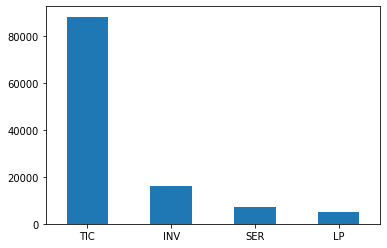

In [21]:
my_tags = df['target'].unique()
df['target'].value_counts().plot(kind="bar", rot=0);

The data is very unbalanced. We have TargetCompany (TIC) as majority class.

# Build baseline models

Let's try to use simple Logistic Regression with word embedding (FastText)

              precision    recall  f1-score   support

         TIC       0.87      0.97      0.92     26467
         INV       0.69      0.53      0.60      4827
          LP       0.62      0.27      0.38      1502
         SER       0.67      0.40      0.50      2198

    accuracy                           0.84     34994
   macro avg       0.71      0.54      0.60     34994
weighted avg       0.83      0.84      0.83     34994

confusion matrix
 [[25628   533   119   187]
 [ 1992  2572    93   170]
 [  853   168   408    73]
 [  859   429    37   873]]
(row=expected, col=predicted)


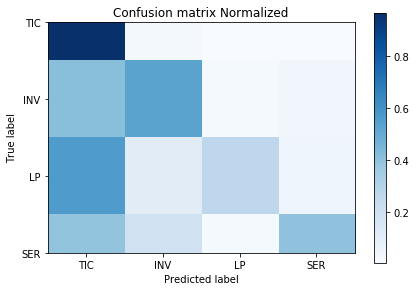

Wall time: 54.8 s


In [22]:
%%time
clf = LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', multi_class='ovr', max_iter=1000)
train_on_fasttext(df, clf)

As we can see, due to imbalanced classes we make many false predictions for the minorities

Let's try to use simple Logistic Regression with Bag of Words (Count Vectorizing)

In [23]:
clf = LogisticRegression(n_jobs=1, C=100, solver='lbfgs', multi_class='ovr', max_iter=10000)
vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize, 
                             preprocessor=None, stop_words='english', max_features=3000)

              precision    recall  f1-score   support

         TIC       0.88      0.96      0.92     26467
         INV       0.74      0.55      0.63      4827
          LP       0.56      0.31      0.40      1502
         SER       0.68      0.47      0.55      2198

    accuracy                           0.85     34994
   macro avg       0.71      0.57      0.62     34994
weighted avg       0.83      0.85      0.83     34994

confusion matrix
 [[25540   505   200   222]
 [ 1871  2635   114   207]
 [  822   154   462    64]
 [  829   283    54  1032]]
(row=expected, col=predicted)


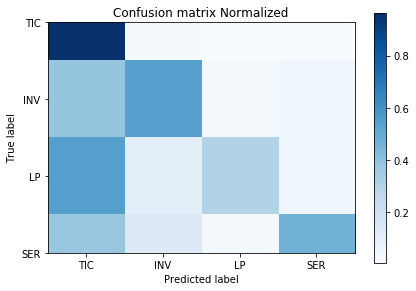

Wall time: 1min 15s


In [24]:
%%time
train_on_count_vectorizer(df, clf, vectorizer)

Results mostly the same as with using word embesddings but using mach less memory

Also, we can see the most influental words for each class

In [25]:
entity_type_id = 3
print(df['target'].unique()[entity_type_id])
most_influential_words(vectorizer, clf, entity_type_id, num_words=20)

SER


['.coms',
 'saved',
 'manufactured',
 'sample',
 'scheduling',
 'automate',
 'easy-to-use',
 'safely',
 'workflow',
 'streamline',
 'sms',
 'packages',
 'fish',
 'categorized',
 'mapping',
 'night',
 'basin',
 'controlled',
 'delicious',
 'detect']

Let's try to use simple Neural Network

W1120 17:02:02.793893 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1120 17:02:02.805892 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 17:02:02.817892 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1120 17:02:02.831894 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1120 17:02:02.837894 22228 deprecation.py:506

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7680512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
__________

W1120 17:02:03.118863 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1120 17:02:03.164895 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1120 17:02:03.176863 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1120 17:02:03.176863 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Train on 57155 samples, validate on 24496 samples
Epoch 1/10


W1120 17:02:06.867685 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1120 17:02:06.867685 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1120 17:02:07.193352 22228 module_wrapper.py:139] From C:\Users\OSHASHLIUK\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



 - 17s - loss: 0.5341 - acc: 0.8413 - val_loss: 0.4670 - val_acc: 0.8593
Epoch 2/10
 - 10s - loss: 0.2987 - acc: 0.9045 - val_loss: 0.5189 - val_acc: 0.8510
Epoch 3/10
 - 10s - loss: 0.1116 - acc: 0.9656 - val_loss: 0.7912 - val_acc: 0.8413
Epoch 4/10
 - 10s - loss: 0.0495 - acc: 0.9871 - val_loss: 0.9987 - val_acc: 0.8407
Epoch 5/10
 - 10s - loss: 0.0380 - acc: 0.9921 - val_loss: 1.0705 - val_acc: 0.8368
Epoch 6/10
 - 10s - loss: 0.0304 - acc: 0.9930 - val_loss: 1.1513 - val_acc: 0.8430
Epoch 7/10
 - 10s - loss: 0.0303 - acc: 0.9932 - val_loss: 1.1823 - val_acc: 0.8384
Epoch 8/10
 - 10s - loss: 0.0297 - acc: 0.9936 - val_loss: 1.2380 - val_acc: 0.8401
Epoch 9/10
 - 10s - loss: 0.0264 - acc: 0.9937 - val_loss: 1.1978 - val_acc: 0.8405
Epoch 10/10
 - 10s - loss: 0.0231 - acc: 0.9948 - val_loss: 1.2157 - val_acc: 0.8333
Test accuracy: 0.8366291364131672
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      4827
           1       0.51    

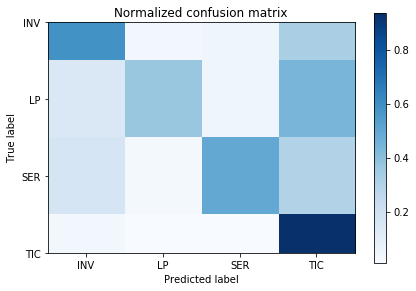

Wall time: 2min 16s


In [26]:
%%time
train_simple_neural_network(df)

Results mostly the same as in the previous models. Probably we should complicate the model or use another tricks such as SMOTE

Let's try to use Random Forest Classifier with Bag of Words (Count Vectorizing)

              precision    recall  f1-score   support

         TIC       0.91      0.84      0.87     26467
         INV       0.63      0.60      0.61      4827
          LP       0.26      0.46      0.33      1502
         SER       0.42      0.59      0.49      2198

    accuracy                           0.78     34994
   macro avg       0.55      0.62      0.58     34994
weighted avg       0.81      0.78      0.79     34994

confusion matrix
 [[22337  1243  1652  1235]
 [ 1251  2899   236   441]
 [  517   149   695   141]
 [  485   338    81  1294]]
(row=expected, col=predicted)


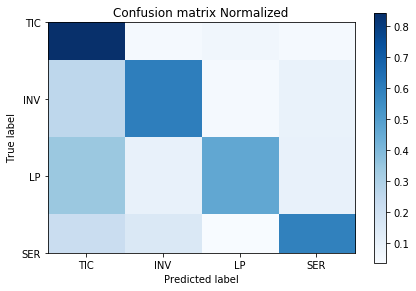

Wall time: 37.6 s


In [27]:
%%time
clf = RandomForestClassifier(bootstrap=True,
                             class_weight='balanced',
                             criterion='gini',
                             max_depth=8,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=4,
                             min_samples_split=10,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=300,
                             oob_score=False,
                             random_state=42,
                             verbose=0,
                             warm_start=False)   
train_on_count_vectorizer(df, clf, vectorizer)

Metrics are slightly worse than previous models, but the recall is much higher than in previous models, i.e. we are much more likely to predict classes with less representation

Let's try to use Light GBM with Bag of Words (Count Vectorizing)

              precision    recall  f1-score   support

         TIC       0.94      0.82      0.88     26467
         INV       0.60      0.66      0.63      4827
          LP       0.28      0.64      0.39      1502
         SER       0.46      0.67      0.54      2198

    accuracy                           0.78     34994
   macro avg       0.57      0.70      0.61     34994
weighted avg       0.84      0.78      0.80     34994

confusion matrix
 [[21748  1696  1893  1130]
 [  780  3205   372   470]
 [  261   153   957   131]
 [  247   317   172  1462]]
(row=expected, col=predicted)


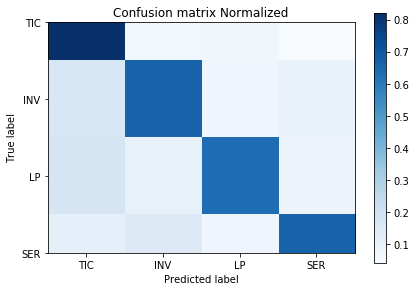

Wall time: 7min 17s


In [28]:
%%time
clf = LGBMClassifier(
    nthread=4,
    objective='multiclass',
    class_weight='balanced',
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=32,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.04,
    reg_lambda=0.073,
    min_split_gain=0.0222415,
    min_child_weight=40,
    silent=-1,
    verbose=-1
)  
vectorizer = CountVectorizer(dtype=np.float32, analyzer="word", tokenizer=nltk.word_tokenize, 
                             preprocessor=None, stop_words='english', max_features=3000)
train_on_count_vectorizer(df, clf, vectorizer)

And results is better for prediction minority classes


# Conclusions

For the baseline models we have try several models with only the basic text preprocessing and without generating new features. On this data, as for me, the Random Forest and Light GBM work better because this algorithms provide us the better predictions for minority classes. So, I propose next steps:
1. Refactor the code of the Primary Entity Type Classifier to use pb_ml library
2. At first sight the predicting of the Primary Investor Type and Primary Service Provider Type are very similar to predicting Primary Entity Type (only the data aquisition and labels to predict are diffirent), so create one pipline for all of this classifiers
3. Use Light GBM model as baseline model
4. Try to use derivatives models from Random Forest (such as various boostings) for improving the baseline model
5. Use some tricks sach as upsampling with SMOTE, ensemble Cross-Validation and feature enginiering for improoving the results